In [13]:
import MDAnalysis as mda
from ase import io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from watdyn.basic import WatAdsCCF
from zjxpack.postprocess import common

In [31]:
def ccf(a, b):
    ts = np.arange(len(a))
    output = []
    for t in ts:
        tmp_a = a[: int(len(a) - t)]
        tmp_b = b[int(t) :]
        tmp_out = np.mean(tmp_a * tmp_b)
        output.append(tmp_out)
    return np.array(output)

read parameters

In [3]:
atoms = io.read("./input_data/coord.xyz")
slab_idx = common.get_elem_idxs(atoms, "Pt")
water_idx = common.get_elem_idxs(atoms, "O")

pre-read trajectory

In [4]:
u = mda.Universe(
    "./input_data/trajectory.xyz", all_coordinates=True, format="XYZ", in_memory=True
)

/home/jxzhu/.conda/envs/soap_ana/lib/python3.9/site-packages/MDAnalysis/coordinates/base.py:892: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


In [48]:
u = mda.Universe(
    "./input_data/interface.psf",
    all_coordinates=True,
    in_memory=True,
    dt=0.5,
    dimensions=[16.869, 16.869, 41.478, 90, 90, 120],
)

<AtomGroup [<Atom 1: O of type O of resname R1, resid 1 and segid MOL1>, <Atom 2: H of type H of resname R1, resid 1 and segid MOL1>, <Atom 3: H of type H of resname R1, resid 1 and segid MOL1>, ..., <Atom 688: O of type O of resname R1, resid 230 and segid MOL1>, <Atom 689: H of type H of resname R1, resid 230 and segid MOL1>, <Atom 690: H of type H of resname R1, resid 230 and segid MOL1>]>


calculate CCF of g and h

In [16]:
data = WatAdsCCF(
    u.atoms,
    cell=[16.869, 16.869, 41.478, 90, 90, 120],
    slab_idx=slab_idx,
    surf_natoms=36,
    water_idx=water_idx,
)

In [17]:
data.run()

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/jxzhu/.conda/envs/band-alignment/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1097: RuntimeWarning: invalid value encountered in true_divide
  return cvf / (np.std(x) * np.std(y))


plot

In [36]:
all_water_g = data.all_water_g
all_water_h = data.all_water_h
all_water_ccf = []
for tmp_data in zip(all_water_h, all_water_g):
    if tmp_data[0][0] == 1 and tmp_data[1].max() == 1:
        h_i = np.mean(tmp_data[0])
        if h_i != 0:
            tmp_ccf = ccf(tmp_data[0], tmp_data[1])
            tmp_ccf = tmp_ccf / h_i
            all_water_ccf.append(tmp_ccf)
water_ccf = np.mean(all_water_ccf, axis=0)
water_ccf_min = np.min(all_water_ccf, axis=0)
water_ccf_max = np.max(all_water_ccf, axis=0)

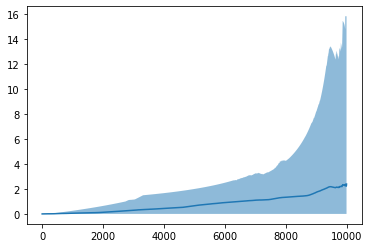

In [37]:
fig, ax = plt.subplots()
x = np.arange(len(water_ccf))
plt.plot(x, water_ccf)
ax.fill_between(x, water_ccf_min, water_ccf_max, alpha=0.5, linewidth=0)
# plt.xscale("log")
# plt.yscale("log")

plt.show()